Right now, this is substantively identical to version 8 of Henrique Mendoça's RCNN model with Coco transfer learning (see fork link at the top).  The first version, which is an exact copy, got a LB score of 0.162.  I've edited the documentaiton and added the plot code here from his later version.   This version probably does not get such a high score, just because there is a lot of randomness between one run and another.

**Mask-RCNN Starter Model for the RSNA Pneumonia Detection Challenge with transfer learning **

Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon
We get the best public kernel performance so far, and also training only within the 6hrs kaggle limit.

In [4]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [5]:
DATA_DIR = '/home/jupyter/rsna-pneumonia-data'
ROOT_DIR = '/home/jupyter/'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [6]:
# !git clone https://www.github.com/matterport/Mask_RCNN.git
# os.chdir('Mask_RCNN')
#!python setup.py -q install

In [7]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [8]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [9]:
### Download COCO pre-trained weights
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "./pneumonia20221214T2308/mask_rcnn_pneumonia_0002.h5" #"mask_rcnn_coco.h5"

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [10]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [11]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [12]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [13]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [14]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [15]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array
# show dicom fields 
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.21457.1517874434.273429
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.21457.1517874434.273429
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [16]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [17]:
# split dataset into training vs. validation dataset 
# split ratio is set to 0.95 vs. 0.05 (train vs. validation, respectively)
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = int(0.05 * len(image_fps_list))
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25350 1334


### Create and prepare the training dataset using the DetectorDataset class.

In [18]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [19]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

In [20]:
# Load and display random sample and their bounding boxes

# class_ids = [0]
# while class_ids[0] == 0:  ## look for a mask
#     image_id = random.choice(dataset_train.image_ids)
#     image_fp = dataset_train.image_reference(image_id)
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)

# print(image.shape)

# plt.figure(figsize=(10, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# masked = np.zeros(image.shape[:2])
# for i in range(mask.shape[2]):
#     masked += image[:, :, 0] * mask[:, :, i]
# plt.imshow(masked, cmap='gray')
# plt.axis('off')

# print(image_fp)
# print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

In [21]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
# imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
# plt.figure(figsize=(30, 12))
# _ = plt.imshow(imggrid[:, :, 0], cmap='gray')

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


### Now it's time to train the model. Note that training even a basic model can take a few hours. 


In [22]:
import keras
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [23]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

2022-12-14 23:55:44.450120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:55:45.314964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:55:45.315472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:55:52.544194: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Re-starting from epoch 2


In [24]:
LEARNING_RATE = 0.005

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [22]:
%%time
time_callback = TimeHistory()
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=2,
            layers='heads',
            augmentation=None,
            custom_callbacks=[time_callback])
times = time_callback.times
times_list = []
times_list.extend(times)
history = model.keras_model.history.history.copy()


Starting at epoch 0. LR=0.005

Checkpoint Path: /home/jupyter/pneumonia20221214T2308/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Time

2022-12-14 23:08:49.056957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:08:49.057489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:08:49.057828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:08:49.058224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:08:49.058544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/2


2022-12-14 23:09:28.685742: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1153 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -41 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -41 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\034\000\000\000\034\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_siz

  1/200 [..............................] - ETA: 2:38:50 - batch: 0.0000e+00 - size: 8.0000 - loss: 12.4070 - rpn_class_loss: 1.6693 - rpn_bbox_loss: 10.7167 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

2022-12-14 23:10:04.632895: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-14 23:10:04.632948: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-14 23:10:04.633007: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-12-14 23:10:05.642071: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-14 23:10:05.647025: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-14 23:10:05.844871: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 4766 callback api events and 4765 activity events. 
2022-12-14 23:10:06.090693: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-14 23:10:06.378150: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/jupyter/pneumonia20221214T2308/p

  2/200 [..............................] - ETA: 7:24 - batch: 0.5000 - size: 8.0000 - loss: 11.7943 - rpn_class_loss: 1.1715 - rpn_bbox_loss: 7.6023 - mrcnn_class_loss: 1.0775 - mrcnn_bbox_loss: 1.6076 - mrcnn_mask_loss: 0.3353                

2022-12-14 23:10:06.728761: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/jupyter/pneumonia20221214T2308/plugins/profile/2022_12_14_23_10_06

2022-12-14 23:10:06.741933: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /home/jupyter/pneumonia20221214T2308/plugins/profile/2022_12_14_23_10_06/34f32647c941.memory_profile.json.gz
2022-12-14 23:10:06.748428: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /home/jupyter/pneumonia20221214T2308/plugins/profile/2022_12_14_23_10_06
Dumped tool data for xplane.pb to /home/jupyter/pneumonia20221214T2308/plugins/profile/2022_12_14_23_10_06/34f32647c941.xplane.pb
Dumped tool data for overview_page.pb to /home/jupyter/pneumonia20221214T2308/plugins/profile/2022_12_14_23_10_06/34f32647c941.overview_page.pb
Dumped tool data for input_pipeline.pb to /home/jupyter/pneumonia20221214T2308/plugins/profile/2022_12_14_23_10

200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 8.0000 - loss: 14.5263 - rpn_class_loss: 0.6217 - rpn_bbox_loss: 7.5394 - mrcnn_class_loss: 0.7329 - mrcnn_bbox_loss: 5.6286 - mrcnn_mask_loss: 0.0037

2022-12-14 23:11:16.989785: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -896 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -28 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -28 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\034\000\000\000\034\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size

200/200 [==============================] - 186s 693ms/step - batch: 99.5000 - size: 8.0000 - loss: 14.5263 - rpn_class_loss: 0.6217 - rpn_bbox_loss: 7.5394 - mrcnn_class_loss: 0.7329 - mrcnn_bbox_loss: 5.6286 - mrcnn_mask_loss: 0.0037 - val_loss: 4.3827 - val_rpn_class_loss: 0.2233 - val_rpn_bbox_loss: 1.4003 - val_mrcnn_class_loss: 1.4934 - val_mrcnn_bbox_loss: 1.2657 - val_mrcnn_mask_loss: 1.7981e-07
Epoch 2/2
200/200 [==============================] - 90s 451ms/step - batch: 99.5000 - size: 8.0000 - loss: 2.9202 - rpn_class_loss: 0.2771 - rpn_bbox_loss: 0.8537 - mrcnn_class_loss: 0.7381 - mrcnn_bbox_loss: 1.0513 - mrcnn_mask_loss: 1.6870e-07 - val_loss: 4.5198 - val_rpn_class_loss: 0.2125 - val_rpn_bbox_loss: 3.4452 - val_mrcnn_class_loss: 0.1646 - val_mrcnn_bbox_loss: 0.6975 - val_mrcnn_mask_loss: 7.4012e-09
CPU times: user 2min 32s, sys: 36.7 s, total: 3min 8s
Wall time: 5min 3s


In [23]:
print('Epoch Training time:', times)
print(history)

Epoch Training time: [185.87911534309387, 89.93181729316711]
{'loss': [14.52625340104103, 2.920219239294529], 'rpn_class_loss': [0.6216818, 0.2770945], 'rpn_bbox_loss': [7.539376, 0.85369647], 'mrcnn_class_loss': [0.7328842, 0.73809403], 'mrcnn_bbox_loss': [5.628623, 1.051334], 'mrcnn_mask_loss': [0.0036877068, 1.6870105e-07], 'val_loss': [4.382680654525757, 4.519847779273987], 'val_rpn_class_loss': [0.22329462, 0.21250427], 'val_rpn_bbox_loss': [1.400268, 3.4452329], 'val_mrcnn_class_loss': [1.4933953, 0.16456474], 'val_mrcnn_bbox_loss': [1.2657222, 0.6975447], 'val_mrcnn_mask_loss': [1.7981137e-07, 7.4012148e-09]}


In [25]:
times_list = [185.87911534309387, 89.93181729316711]
history = {'loss': [14.52625340104103, 2.920219239294529], 'rpn_class_loss': [0.6216818, 0.2770945], 'rpn_bbox_loss': [7.539376, 0.85369647], 'mrcnn_class_loss': [0.7328842, 0.73809403], 'mrcnn_bbox_loss': [5.628623, 1.051334], 'mrcnn_mask_loss': [0.0036877068, 1.6870105e-07], 'val_loss': [4.382680654525757, 4.519847779273987], 'val_rpn_class_loss': [0.22329462, 0.21250427], 'val_rpn_bbox_loss': [1.400268, 3.4452329], 'val_mrcnn_class_loss': [1.4933953, 0.16456474], 'val_mrcnn_bbox_loss': [1.2657222, 0.6975447], 'val_mrcnn_mask_loss': [1.7981137e-07, 7.4012148e-09]}

In [26]:
%%time
time_callback = TimeHistory()
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=7,
            layers='all',
            augmentation=augmentation,
           custom_callbacks=[time_callback])

times = time_callback.times
times_list.extend(times)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 2. LR=0.005

Checkpoint Path: /home/jupyter/pneumonia20221214T2308/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b    

2022-12-14 23:58:15.936459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:58:15.937007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:58:15.937288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:58:15.937675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 23:58:15.937973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 3/7


2022-12-15 00:00:45.229469: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1279 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -41 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -41 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\034\000\000\000\034\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_siz

  1/200 [..............................] - ETA: 6:26:11 - batch: 0.0000e+00 - size: 8.0000 - loss: 34.9966 - rpn_class_loss: 15.0859 - rpn_bbox_loss: 18.2542 - mrcnn_class_loss: 1.6566 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

2022-12-15 00:01:40.317902: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-15 00:01:40.317980: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-15 00:01:40.318033: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-12-15 00:01:42.252201: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-15 00:01:42.265555: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-15 00:01:42.701408: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 8347 callback api events and 8346 activity events. 
2022-12-15 00:01:43.808494: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-15 00:01:45.843424: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/jupyter/pneumonia20221214T2308/p

200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 8.0000 - loss: 2.2019 - rpn_class_loss: 0.2017 - rpn_bbox_loss: 0.7649 - mrcnn_class_loss: 0.4836 - mrcnn_bbox_loss: 0.7355 - mrcnn_mask_loss: 0.0161

2022-12-15 00:06:07.654937: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -896 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -28 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -28 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\034\000\000\000\034\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size

200/200 [==============================] - 548s 2s/step - batch: 99.5000 - size: 8.0000 - loss: 2.2019 - rpn_class_loss: 0.2017 - rpn_bbox_loss: 0.7649 - mrcnn_class_loss: 0.4836 - mrcnn_bbox_loss: 0.7355 - mrcnn_mask_loss: 0.0161 - val_loss: 1.6915 - val_rpn_class_loss: 0.0797 - val_rpn_bbox_loss: 0.4311 - val_mrcnn_class_loss: 0.5427 - val_mrcnn_bbox_loss: 0.6373 - val_mrcnn_mask_loss: 7.8826e-04
Epoch 4/7
200/200 [==============================] - 315s 2s/step - batch: 99.5000 - size: 8.0000 - loss: 1.5224 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 0.3858 - mrcnn_class_loss: 0.4659 - mrcnn_bbox_loss: 0.5893 - mrcnn_mask_loss: 6.8863e-04 - val_loss: 1.7280 - val_rpn_class_loss: 0.0733 - val_rpn_bbox_loss: 0.4580 - val_mrcnn_class_loss: 0.5649 - val_mrcnn_bbox_loss: 0.6315 - val_mrcnn_mask_loss: 2.2781e-04
Epoch 5/7
200/200 [==============================] - 429s 2s/step - batch: 99.5000 - size: 8.0000 - loss: 1.5440 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 0.4101 - mrcnn_class_loss: 

In [27]:
print('Epoch Training time:', times)
print(history)

Epoch Training time: [548.3073365688324, 315.4393117427826, 429.21446919441223, 441.90249371528625, 451.62142634391785]
{'loss': [14.52625340104103, 2.920219239294529, 2.201862550973892, 1.5224493128061294, 1.543996348977089, 1.5335412353277207, 1.4682456463575364], 'rpn_class_loss': [0.6216818, 0.2770945, 0.20172833, 0.0807244, 0.07475084, 0.08410248, 0.07544587], 'rpn_bbox_loss': [7.539376, 0.85369647, 0.76491934, 0.38578588, 0.41013923, 0.42178383, 0.37878516], 'mrcnn_class_loss': [0.7328842, 0.73809403, 0.48361835, 0.46592033, 0.4798547, 0.44388306, 0.43880072], 'mrcnn_bbox_loss': [5.628623, 1.051334, 0.7354679, 0.5893301, 0.57880574, 0.583379, 0.5749506], 'mrcnn_mask_loss': [0.0036877068, 1.6870105e-07, 0.016128808, 0.00068863184, 0.0004457589, 0.00039289697, 0.00026326295], 'val_loss': [4.382680654525757, 4.519847779273987, 1.6915145015716553, 1.7279615259170533, 1.6561826109886169, 1.662349808216095, 1.6928636479377746], 'val_rpn_class_loss': [0.22329462, 0.21250427, 0.07972044,

In [28]:
%%time
time_callback = TimeHistory()
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=15,
            layers='all',
            augmentation=augmentation,
            custom_callbacks=[time_callback])

times = time_callback.times
times_list.extend(times)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 7. LR=0.001

Checkpoint Path: /home/jupyter/pneumonia20221214T2308/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b    

2022-12-15 00:44:07.700286: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1279 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -41 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -41 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\034\000\000\000\034\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_siz

  1/200 [..............................] - ETA: 4:43:30 - batch: 0.0000e+00 - size: 8.0000 - loss: 3.2926 - rpn_class_loss: 0.0992 - rpn_bbox_loss: 0.4828 - mrcnn_class_loss: 0.5039 - mrcnn_bbox_loss: 0.5603 - mrcnn_mask_loss: 1.0807e-04

2022-12-15 00:44:24.232382: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-15 00:44:24.232442: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-15 00:44:26.602154: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-15 00:44:26.618554: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-15 00:44:27.371714: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 8514 callback api events and 8513 activity events. 
2022-12-15 00:44:28.659482: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-15 00:44:30.181209: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/jupyter/pneumonia20221214T2308/plugins/profile/2022_12_15_00_44_28

2022-12-15 00:44:31.132158: I tensorflow/core/profiler/rpc/client/save_profi

200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 8.0000 - loss: 2.9065 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.4219 - mrcnn_bbox_loss: 0.5545 - mrcnn_mask_loss: 2.2078e-04

2022-12-15 00:49:20.903177: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -896 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -28 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -28 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\034\000\000\000\034\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size

200/200 [==============================] - 418s 2s/step - batch: 99.5000 - size: 8.0000 - loss: 2.9065 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.4219 - mrcnn_bbox_loss: 0.5545 - mrcnn_mask_loss: 2.2078e-04 - val_loss: 3.1698 - val_rpn_class_loss: 0.0582 - val_rpn_bbox_loss: 0.4438 - val_mrcnn_class_loss: 0.4809 - val_mrcnn_bbox_loss: 0.6018 - val_mrcnn_mask_loss: 1.6368e-04
Epoch 9/15
200/200 [==============================] - 437s 2s/step - batch: 99.5000 - size: 8.0000 - loss: 2.7730 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.4097 - mrcnn_bbox_loss: 0.5405 - mrcnn_mask_loss: 2.6193e-04 - val_loss: 3.0803 - val_rpn_class_loss: 0.0632 - val_rpn_bbox_loss: 0.4070 - val_mrcnn_class_loss: 0.4634 - val_mrcnn_bbox_loss: 0.6061 - val_mrcnn_mask_loss: 5.1256e-04
Epoch 10/15
200/200 [==============================] - 433s 2s/step - batch: 99.5000 - size: 8.0000 - loss: 2.8385 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 0.3945 - mrcnn_class

In [29]:
print('Epoch Training time:', times)
print(history)

Epoch Training time: [418.2546012401581, 436.84853172302246, 433.4643096923828, 452.2518992424011, 425.5893085002899, 450.37851452827454, 417.9939739704132, 453.8830142021179]
{'loss': [14.52625340104103, 2.920219239294529, 2.201862550973892, 1.5224493128061294, 1.543996348977089, 1.5335412353277207, 1.4682456463575364, 2.906486257314682, 2.7730079770088194, 2.838539335727692, 2.7608440566062926, 2.794515290260315, 2.9374066507816314, 2.929827147722244, 2.97077424287796], 'rpn_class_loss': [0.6216818, 0.2770945, 0.20172833, 0.0807244, 0.07475084, 0.08410248, 0.07544587, 0.07017115, 0.06347559, 0.06579848, 0.064049914, 0.06776536, 0.068569005, 0.064036466, 0.062203225], 'rpn_bbox_loss': [7.539376, 0.85369647, 0.76491934, 0.38578588, 0.41013923, 0.42178383, 0.37878516, 0.4064187, 0.37256417, 0.3945341, 0.3846083, 0.36766773, 0.42694244, 0.41284794, 0.4375618], 'mrcnn_class_loss': [0.7328842, 0.73809403, 0.48361835, 0.46592033, 0.4798547, 0.44388306, 0.43880072, 0.42190945, 0.4097131, 0.4

In [30]:
epochs = range(1,len(next(iter(history.values())))+1)
df = pd.DataFrame(history, index=epochs)
df['epoch_train_time'] = times_list
df.to_csv(ROOT_DIR + 'v100-loss.csv')

In [31]:
df.head()

,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,epoch_train_time
1,14.526253,0.621682,7.539376,0.732884,5.628623,3.687707e-03,4.382681,0.223295,1.400268,1.493395,1.265722,1.798114e-07,185.879115
2,2.920219,0.277095,0.853696,0.738094,1.051334,1.687010e-07,4.519848,0.212504,3.445233,0.164565,0.697545,7.401215e-09,89.931817
3,2.201863,0.201728,0.764919,0.483618,0.735468,1.612881e-02,1.691515,0.079720,0.431067,0.542675,0.637263,7.882574e-04,548.307337
4,1.522449,0.080724,0.385786,0.465920,0.589330,6.886318e-04,1.727962,0.073304,0.458028,0.564895,0.631507,2.278085e-04,315.439312
5,1.543996,0.074751,0.410139,0.479855,0.578806,4.457589e-04,1.656183,0.068662,0.458250,0.497556,0.631569,1.460264e-04,429.214469


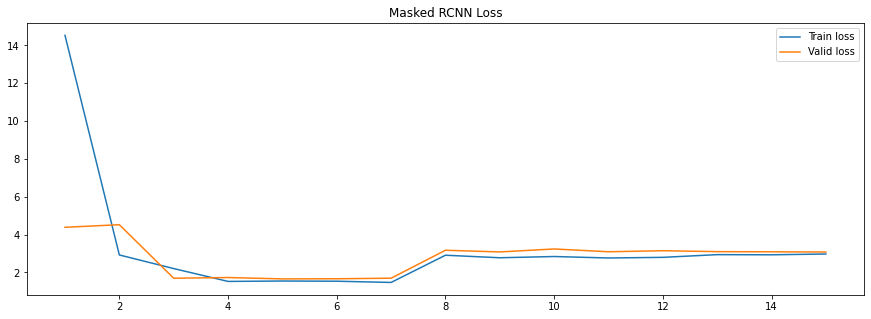

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(111)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.title('Masked RCNN Loss')
plt.legend()
plt.savefig('v100-mrccn-loss-plot.png')
# plt.show()

In [33]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in /home/jupyter/pneumonia20221214T0103
No weight files in /home/jupyter/pneumonia20221214T0109
No weight files in /home/jupyter/pneumonia20221214T0155
No weight files in /home/jupyter/pneumonia20221214T0159
No weight files in /home/jupyter/pneumonia20221214T0207
No weight files in /home/jupyter/pneumonia20221214T0256
No weight files in /home/jupyter/pneumonia20221214T0732
Found model /home/jupyter/pneumonia20221214T2308/mask_rcnn_pneumonia_0015.h5


In [34]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/jupyter/pneumonia20221214T2308/mask_rcnn_pneumonia_0015.h5
Re-starting from epoch 15


### Final steps - Create the submission file

In [35]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

In [36]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [ ]:
submission_fp = os.path.join(ROOT_DIR, 'submission-0.95.csv')
predict(test_image_fps, filepath=submission_fp, min_conf=0.95)
print(submission_fp)

  0% 0/3000 [00:00<?, ?it/s]2022-12-15 01:44:20.233262: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -50 } dim { size: -208 } dim { size: -209 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\007\000\000\000\007\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-16GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache